In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ReLU

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
ddf = pd.read_csv('all_faults.csv')
ddf.shape

(3015936, 2)

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=1000
stride=200

X=[]
Y=[]


for k in ddf['fault'].unique():
    
    df_temp_2 = ddf[ddf['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],win_len))



Y=np.array(Y)
encode= LabelEncoder()
encode.fit(Y)
encoded_Y = encode.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [5]:
np.shape(X)

(15042, 1000)

In [6]:
Y.shape

(15042,)

In [41]:
OHE_Y.shape

(15042, 8)

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.8,shuffle=True)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

(3008, 1000)
(12034, 1000)
(3008, 8)
(12034, 8)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
n_inputs = X.shape[1]
input_data_shape= Input(shape=(n_inputs,))
encoder= Dense(n_inputs)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= ReLU()(encoder)
encoder= Dense(n_inputs/2)(encoder)
encoder= BatchNormalization()(encoder)
encoder= ReLU()(encoder)
encoder= Dense(n_inputs/4)(encoder)
encoder= BatchNormalization()(encoder)
encoder= ReLU()(encoder)
##n_bottleneck = round(float(n_inputs) / 8)
##bottleneck = Dense(n_bottleneck)(encoder)
encoder= Dense(n_inputs/8)(encoder)
encoder= BatchNormalization()(encoder)
encoder= ReLU()(encoder)
bottleneck= encoder
decoder = Dense(n_inputs/4)(encoder)
decoder = BatchNormalization()(decoder)
decoder = ReLU()(decoder)
decoder = Dense(n_inputs/2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = ReLU()(decoder)
decoder = Dense(n_inputs)(decoder)
decoder = BatchNormalization()(decoder)
decoder = ReLU()(decoder)

In [10]:
output = Dense(n_inputs/125, activation='linear')(decoder)
model = Model(inputs=input_data_shape, outputs=output)
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 batch_normalization_1 (Batc  (None, 500)              2000      
 hNormalization)                                             

In [11]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_test,y_test))

Epoch 1/20
94/94 - 14s - loss: 0.5218 - val_loss: 0.1344 - 14s/epoch - 147ms/step
Epoch 2/20
94/94 - 8s - loss: 0.2483 - val_loss: 0.9142 - 8s/epoch - 87ms/step
Epoch 3/20
94/94 - 9s - loss: 0.1457 - val_loss: 2.7225 - 9s/epoch - 91ms/step
Epoch 4/20
94/94 - 8s - loss: 0.1254 - val_loss: 0.9452 - 8s/epoch - 86ms/step
Epoch 5/20
94/94 - 9s - loss: 0.1087 - val_loss: 0.3867 - 9s/epoch - 94ms/step
Epoch 6/20
94/94 - 8s - loss: 0.0907 - val_loss: 0.2215 - 8s/epoch - 87ms/step
Epoch 7/20
94/94 - 11s - loss: 0.0784 - val_loss: 0.1789 - 11s/epoch - 113ms/step
Epoch 8/20
94/94 - 10s - loss: 0.0677 - val_loss: 0.1700 - 10s/epoch - 110ms/step
Epoch 9/20
94/94 - 10s - loss: 0.0664 - val_loss: 0.2304 - 10s/epoch - 106ms/step
Epoch 10/20
94/94 - 10s - loss: 0.0592 - val_loss: 0.2002 - 10s/epoch - 111ms/step
Epoch 11/20
94/94 - 10s - loss: 0.0551 - val_loss: 0.1982 - 10s/epoch - 104ms/step
Epoch 12/20
94/94 - 10s - loss: 0.0514 - val_loss: 0.3789 - 10s/epoch - 108ms/step
Epoch 13/20
94/94 - 10s - lo

In [12]:
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
encoder.save('encoder.h5')

In [13]:
y_pred=model.predict(X_test)
print(y_pred)
print(y_pred.shape)

[[ 1.0128354e+00  2.9233271e-02 -6.2301271e-02 ...  3.2291278e-02
   1.6725894e-02 -1.9246420e-02]
 [-5.8106095e-02 -8.3980542e-03 -5.6007579e-02 ...  1.2621972e-01
   4.8454829e-02 -2.8703490e-02]
 [ 1.0931022e+00  1.8082613e-02 -5.6567691e-02 ...  2.7989475e-02
  -8.6585805e-04 -2.4657549e-02]
 ...
 [-3.5211936e-02 -3.0840619e-02 -3.3067673e-02 ...  9.2464365e-02
   3.2057561e-02 -6.0338989e-02]
 [-1.8636825e-02  5.4011960e-03  8.9823723e-01 ...  1.3804193e-01
   4.4511199e-02 -5.0643958e-02]
 [-6.6067614e-02 -2.4412693e-02 -6.9108360e-02 ...  1.0150603e-01
   1.2447622e-01  5.8933675e-02]]
(12034, 8)


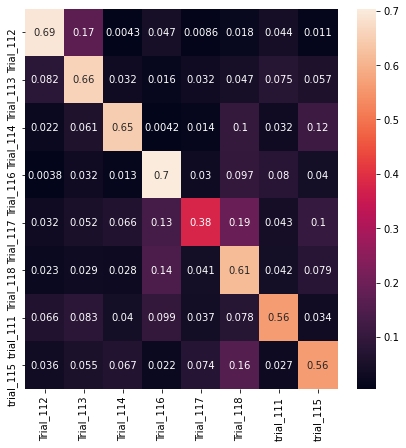

In [14]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encode.inverse_transform(y_pred)
    return y_pred






Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(7,7))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encode.classes_,yticklabels=encode.classes_)
plt.show()

In [15]:
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.70      0.69      0.70      1394
           1       0.59      0.66      0.62      1543
           2       0.70      0.65      0.67      1412
           3       0.62      0.70      0.66      1584
           4       0.63      0.38      0.47      1597
           5       0.44      0.61      0.51      1371
           6       0.63      0.56      0.60      1572
           7       0.57      0.56      0.57      1561

    accuracy                           0.60     12034
   macro avg       0.61      0.60      0.60     12034
weighted avg       0.61      0.60      0.60     12034



In [16]:
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)
X = encoder.predict(X)

In [17]:
sample_size=X.shape[0]
time_steps=X.shape[1]
input_dimension=1
X_reshaped=X.reshape(sample_size,time_steps,input_dimension)

print("After reshape:\n",X_reshaped.shape)
print(X_reshaped.shape[0])
print(X_reshaped.shape[1])
print(X_reshaped.shape[2])
print("Sample shape:\n",X_reshaped[0].shape)
print("An example sample :\n",X_reshaped[0])

After reshape:
 (15042, 125, 1)
15042
125
1
Sample shape:
 (125, 1)
An example sample :
 [[0.0000000e+00]
 [2.1095896e+00]
 [4.7616920e-01]
 [2.1588821e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.2891247e-01]
 [0.0000000e+00]
 [4.5350361e-01]
 [1.2610824e+00]
 [1.4003520e+00]
 [0.0000000e+00]
 [1.6295704e-01]
 [1.4401931e+00]
 [9.5973969e-02]
 [8.2479954e-02]
 [3.4486303e+00]
 [5.6542134e-01]
 [3.3545136e-01]
 [2.7207649e-01]
 [0.0000000e+00]
 [1.3976579e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [8.4541339e-01]
 [1.3751423e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.7990470e+00]
 [6.3154417e-01]
 [3.3943195e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [8.8258344e-01]
 [0.0000000e+00]
 [2.6220933e-01]
 [0.0000000e+00]
 [1.6651964e-01]
 [2.4310136e+00]
 [7.3604691e-01]
 [1.4912164e-01]
 [0.0000000e+00]
 [1.6459012e-01]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0733107e+00]
 [0.0000000e+00]
 [0.000000

In [18]:
sample_size=X_train_encode.shape[0]
time_steps=X_train_encode.shape[1]
input_dimension=1
X_train=X_train_encode.reshape(sample_size,time_steps,input_dimension)

print("After reshape:\n",X_train.shape)
print(X_train.shape[0])
print(X_train.shape[1])
print(X_train.shape[2])
print("Sample shape:\n",X_train[0].shape)
print("An example sample :\n",X_train[0])

After reshape:
 (3008, 125, 1)
3008
125
1
Sample shape:
 (125, 1)
An example sample :
 [[0.        ]
 [0.38874996]
 [0.34182438]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.65101963]
 [0.15882039]
 [2.5094588 ]
 [1.1743855 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.5066874 ]
 [1.0531795 ]
 [0.        ]
 [0.        ]
 [1.8889886 ]
 [0.        ]
 [0.        ]
 [0.17351931]
 [0.05770439]
 [1.9492862 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.146124  ]
 [0.        ]
 [0.01196164]
 [0.98414755]
 [0.14257991]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.2770412 ]
 [0.        ]
 [0.        ]
 [0.12023702]
 [0.        ]
 [0.9338535 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.54417026]
 [0.        ]
 [0.23564598]
 [0.        ]
 [0.        ]
 [2.7181988 ]
 [0.076648  ]
 [0.        ]
 [0.47185862]
 [0.        ]
 [0.        ]
 [0.08751202]
 [0.        ]
 [0.88408875]
 [0.        ]
 [0.        ]
 [1

In [19]:
sample_size=X_test_encode.shape[0]
time_steps=X_test_encode.shape[1]
input_dimension=1
X_test=X_test_encode.reshape(sample_size,time_steps,input_dimension)

print("After reshape:\n",X_test.shape)
print(X_test.shape[0])
print(X_test.shape[1])
print(X_test.shape[2])
print("Sample shape:\n",X_test[0].shape)
print("An example sample :\n",X_test[0])

After reshape:
 (12034, 125, 1)
12034
125
1
Sample shape:
 (125, 1)
An example sample :
 [[0.7122054 ]
 [0.8861445 ]
 [0.07563135]
 [0.56712824]
 [0.18557812]
 [1.0419656 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.6036159 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.09288052]
 [0.1620146 ]
 [0.06158702]
 [0.        ]
 [0.38832244]
 [0.        ]
 [0.5519391 ]
 [0.        ]
 [1.1553099 ]
 [0.2586807 ]
 [0.7265359 ]
 [0.        ]
 [0.06509471]
 [0.        ]
 [0.        ]
 [0.9678604 ]
 [0.58164066]
 [0.        ]
 [0.06694782]
 [1.3094829 ]
 [0.        ]
 [0.8109318 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.20492396]
 [0.        ]
 [0.3864387 ]
 [0.        ]
 [0.        ]
 [0.74892926]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.54308915]
 [0.5512186 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.2935444 ]
 

In [55]:
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X )

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15042 samples in 0.002s...


C:\Users\abulf\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 15042 samples in 10.950s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15042
[t-SNE] Computed conditional probabilities for sample 2000 / 15042
[t-SNE] Computed conditional probabilities for sample 3000 / 15042
[t-SNE] Computed conditional probabilities for sample 4000 / 15042
[t-SNE] Computed conditional probabilities for sample 5000 / 15042
[t-SNE] Computed conditional probabilities for sample 6000 / 15042
[t-SNE] Computed conditional probabilities for sample 7000 / 15042
[t-SNE] Computed conditional probabilities for sample 8000 / 15042
[t-SNE] Computed conditional probabilities for sample 9000 / 15042
[t-SNE] Computed conditional probabilities for sample 10000 / 15042
[t-SNE] Computed conditional probabilities for sample 11000 / 15042
[t-SNE] Computed conditional probabilities for sample 12000 / 15042
[t-SNE] Computed conditional probabilities for sample 13000 / 15042
[t-SNE] Computed conditional probabilities for sample 14000 / 1504

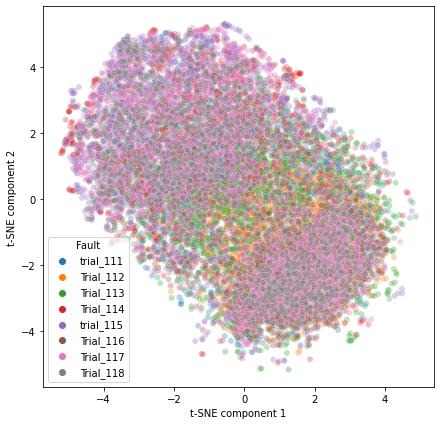

In [56]:
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])
tSNEdf['Fault']=Y

fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [57]:
tSNEdf

,t-SNE component 1,t-SNE component 2,Fault
0,-2.392637,4.762880,trial_111
1,-3.718724,1.270436,trial_111
2,-2.000090,2.996871,trial_111
3,-3.408967,2.750270,trial_111
4,-2.774161,4.570296,trial_111
...,...,...,...
15037,-2.585090,1.925718,Trial_118
15038,-1.425197,1.805323,Trial_118
15039,-3.037367,1.293751,Trial_118
15040,-1.446480,1.558744,Trial_118


In [20]:
from keras.layers import GRU

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten



no_classes=len(encode.classes_)
model = Sequential()
model.add(GRU(125, return_sequences=True, input_shape=(X_reshaped.shape[1],1), activation='tanh'))
model.add(GRU(250, return_sequences=False, activation='tanh'))
model.add(Dense(500, activation='relu'))
model.add(Dense(750, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125, 125)          48000     
                                                                 
 gru_1 (GRU)                 (None, 250)               282750    
                                                                 
 dense_8 (Dense)             (None, 500)               125500    
                                                                 
 dense_9 (Dense)             (None, 750)               375750    
                                                                 
 dense_10 (Dense)            (None, 1000)              751000    
                                                                 
 dense_11 (Dense)            (None, 8)                 8008      
                                                                 
Total params: 1,591,008
Trainable params: 1,591,008
Non-

In [ ]:
history = model.fit(X_train ,
                    y_train,
                    epochs=20, 
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_test ,y_test),
                    verbose=1)

Epoch 1/20
94/94 [==============================] - 102s 1s/step - loss: 1.4958 - accuracy: 0.4515 - val_loss: 1.9084 - val_accuracy: 0.4007
Epoch 2/20
94/94 [==============================] - 106s 1s/step - loss: 0.7828 - accuracy: 0.7247 - val_loss: 2.6203 - val_accuracy: 0.4083
Epoch 3/20
94/94 [==============================] - 104s 1s/step - loss: 0.6131 - accuracy: 0.7869 - val_loss: 2.1654 - val_accuracy: 0.4444
Epoch 4/20
94/94 [==============================] - 106s 1s/step - loss: 0.5190 - accuracy: 0.8261 - val_loss: 2.5538 - val_accuracy: 0.4464
Epoch 5/20
61/94 [==================>...........] - ETA: 16s - loss: 0.4805 - accuracy: 0.8345

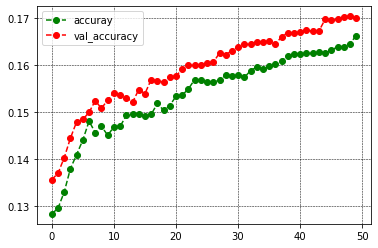

In [62]:
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['accuray','val_accuracy'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

In [63]:
y_pred=model.predict(X_test)
print(y_pred)
print(y_pred.shape)

[[0.12510435 0.12689446 0.12085289 ... 0.12066304 0.12622686 0.1249184 ]
 [0.11756172 0.12579226 0.12484232 ... 0.12169375 0.1271818  0.13000013]
 [0.1034562  0.12174205 0.13512602 ... 0.12830178 0.12774566 0.14354537]
 ...
 [0.1141647  0.12508224 0.12747836 ... 0.12344061 0.12735885 0.13323864]
 [0.11928322 0.12611185 0.12365129 ... 0.1211158  0.12701534 0.12861855]
 [0.09908193 0.1200092  0.13806261 ... 0.13033906 0.12775183 0.14841542]]
(6017, 8)


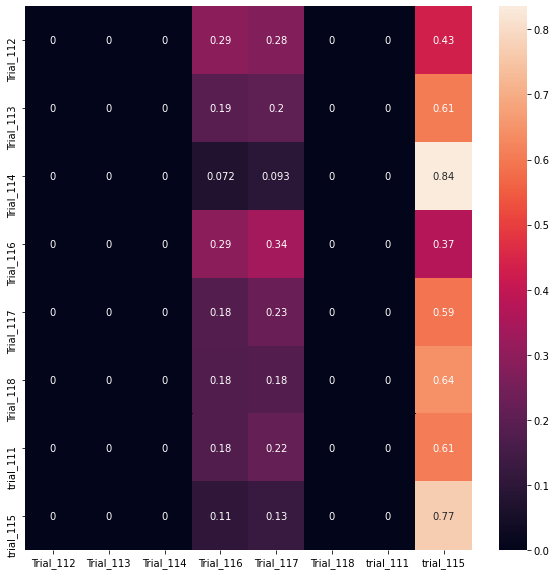

In [64]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encode.inverse_transform(y_pred)
    return y_pred






Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encode.classes_,yticklabels=encode.classes_)
plt.show()

In [65]:
print(X_train.shape)
print(X_test.shape)
print(X_train_encode.shape)
print(X_test_encode.shape)
print(y_train.shape)
print(y_test.shape)

(9025, 125, 1)
(6017, 125, 1)
(9025, 125)
(6017, 125)
(9025, 8)
(6017, 8)


In [66]:
dummy_ann = Model(inputs=model.input,outputs=model.layers[-3].output)
y_viz = dummy_ann.predict(X_train)
y_viz.shape

(9025, 750)

In [67]:
def T_SNE_plot(X_train,y_train,model,encode):
    
    dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
    y_viz = dummy_ann.predict(X_train_encode)
    
    from sklearn.manifold import TSNE

    X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

    tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

    tSNEdf['Fault']=inv_Transform_result(y_train)


    # Plot the PC-1 and PC-2
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
        data=tSNEdf,
        legend="full",
        alpha=0.3)
    plt.show()

C:\Users\abulf\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9025 samples in 0.016s...
[t-SNE] Computed neighbors for 9025 samples in 2.731s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9025
[t-SNE] Computed conditional probabilities for sample 2000 / 9025
[t-SNE] Computed conditional probabilities for sample 3000 / 9025
[t-SNE] Computed conditional probabilities for sample 4000 / 9025
[t-SNE] Computed conditional probabilities for sample 5000 / 9025
[t-SNE] Computed conditional probabilities for sample 6000 / 9025
[t-SNE] Computed conditional probabilities for sample 7000 / 9025
[t-SNE] Computed conditional probabilities for sample 8000 / 9025
[t-SNE] Computed conditional probabilities for sample 9000 / 9025
[t-SNE] Computed conditional probabilities for sample 9025 / 9025
[t-SNE] Mean sigma: 0.003421
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.137283
[t-SNE] KL divergence after 300 iterations: 2.062735


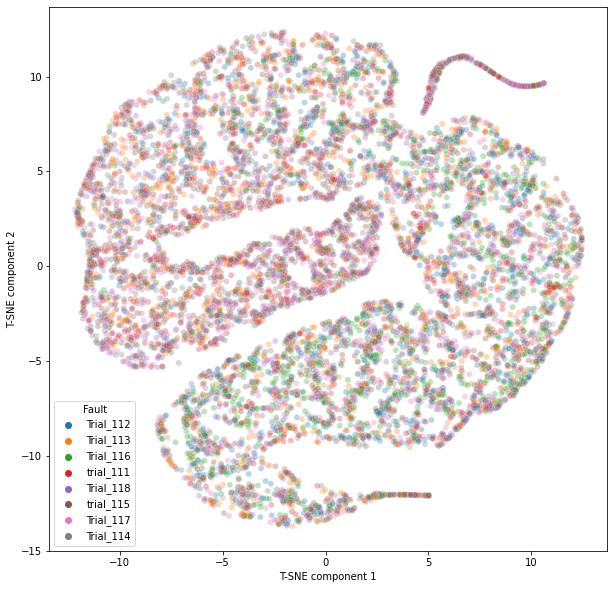

In [68]:
T_SNE_plot(X_train,y_train,model,encode)

In [69]:
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       679
           1       0.00      0.00      0.00       799
           2       0.00      0.00      0.00       681
           3       0.21      0.29      0.24       783
           4       0.14      0.23      0.17       747
           5       0.00      0.00      0.00       712
           6       0.00      0.00      0.00       803
           7       0.17      0.77      0.28       813

    accuracy                           0.17      6017
   macro avg       0.06      0.16      0.09      6017
weighted avg       0.07      0.17      0.09      6017



C:\Users\abulf\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels : list, optional
C:\Users\abulf\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels : list, optional
C:\Users\abulf\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels : list, optional
